## Fix demuxing
of temperature replica exchange trajectories for oligomers

In [1]:
import time, os
import numpy as np
import MDAnalysis as mda
from scipy.spatial import distance
import matplotlib.pyplot as plt

### basic function: `demuxing`

`demuxing` will give `replica_index` (columns then `replica_temp = np.argsort(replica_index, axis=1)`

https://gromacs.bioexcel.eu/t/difference-between-replica-index-xvg-and-replica-temp-xvg/5540

- `replica_index` and `replica_temp` are mutually inverse: `replica_temp` shows the diffusion of each replica in temperature space, i.e. each replica (column) is at what temperature; `replica_index` shows the opposite, i.e. each temperature (column) is at which replica

In [2]:
def main_demuxing(x, x_new, threshold = 1e-3, n_replicas = 24, if_assert = True):
    """ this is the inner function of demuxing (NOT imported there) """

    # if (type(my_fun) is float) or (type(my_fun) is int):
    # my_fun = lambda x1, x2 : len(np.where(np.abs(x1 - x2) < threshold)[0])

    def my_fun(x1, x2):
        diff = np.abs(x1 - x2)
        arg = 2*np.pi*(diff[::3] + diff[1::3] + np.sqrt(2)*diff[2::3])
        # cos_dist = 1 - np.cos(arg)
        cos_dist = 1 - np.cos(np.sum(arg))
        return cos_dist
    
    diff = distance.cdist(x, x_new, my_fun)
    """ diff[i, j] is the distance between x[i] and x_new[j] """

    ind = np.argmax(diff, axis=0)
    """ ind[i] is the index of x_new which is the closest to x[i] """

    # you should add a check on unique assignment!
    assert len(np.unique(ind)) == n_replicas
    
    # if len(np.unique(ind)) != n_replicas:
    #     print('error')
    
    return diff, ind

In [2]:
def get_trajectory(paths_traj, n_replicas = 24, start_frame = 0, sup_trajs = None, sup_frames = -1):

    trajs = []

    if sup_trajs is None: sup_trajs = len(paths_traj)

    for n_subtraj in range(sup_trajs):
        
        xtc_read = []  # xtc_read[NR][n_frame][:]
        for n_rep in range(n_replicas):
            xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % n_rep))
        
        n_frame0 = start_frame
        
        if n_subtraj == 0:
            x = []
            for n_rep in range(n_replicas):
                x.append(xtc_read[n_rep][start_frame][:].flatten())
            
            trajs.append(np.array(x))
            n_frame0 = start_frame + 1  # if already initialised, start from next frame
        
        if sup_frames == -1: sup_frames = len(xtc_read[0])
        
        for n_frame in range(n_frame0, sup_frames):
            x_new = []
            for n_rep in range(n_replicas):
                x_new.append(xtc_read[n_rep][n_frame][:].flatten())

            trajs.append(np.array(x_new))

            if (n_frame % 10) == 0:
                print('n frames: ', n_frame)

        return trajs

In [3]:
from demuxing_fun import demuxing

### select trajectories and do demuxing on those

In [3]:
sequence = 'GACC'
n_replicas = 24

curr_dir = '/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (sequence, sequence)

# n_max_subtraj = 100  # 310 for UCAAUC, 100 for UCUCGU (?)

# start_frame = 0

In [4]:
paths_traj = [s for s in os.listdir(curr_dir) if s.startswith('traj_comp0')]  #  and s.endswith('0002.xtc'))]
paths_traj = [s for s in paths_traj if not (s.endswith('full_proc.xtc') or s.endswith('full.xtc'))]

paths_traj.sort()

# first element is traj_comp0.xtc
paths_traj.insert(0, paths_traj[-1])
paths_traj = paths_traj[:-1]

# substitute replica number with %s
for i in range(len(paths_traj)):
    index = 9
    replacement = '%s'

    text_list = list(paths_traj[i])
    text_list[index] = replacement

    paths_traj[i] = ''.join(text_list)

paths_traj = [(curr_dir + '/' + s) for s in paths_traj]



In [5]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.p

In [6]:
ts = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0).ts.dimensions

ts

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


array([51.0528  , 51.0528  , 51.052814, 60.000008, 60.000008, 90.      ],
      dtype=float32)

In [7]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.p

In [3]:
!du -hs /net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC

1,8T	/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC


In [6]:
path_print = '../../demuxing'

my_rep_index = demuxing(1e-3, n_replicas, paths_traj, True, path_print, n_print=10)


subtrajectory n.  0


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90
0


In [70]:
my_rep_index

array([[ 0,  1,  2, ..., 21, 22, 23],
       [ 0,  1,  3, ..., 20, 22, 23],
       [ 1,  0,  2, ..., 20, 22, 23],
       ...,
       [ 4, 21, 16, ...,  5, 19,  1],
       [ 4, 16, 21, ..., 18,  1, 19],
       [16,  4, 21, ..., 18,  1, 19]])

### import *replica_index* by Salvo (done with Plumed)

skip first frame/row (because done for `my_rep_index`) and skip first column (because frame index)

no!! do not skip first frame!

In [5]:
os.getcwd()

path = '../../../../../../net/sbp/srnas2/sdimarco/AAAA/demuxing/'
my_list = os.listdir(path)

list(filter(lambda x: x.startswith('replica'), my_list))


['replica_temp_cat.xvg',
 'replica_index_cat.xvg',
 'replica_temp0002.xvg',
 'replica_index0002.xvg',
 'replica_temp0003.xvg',
 'replica_index0003.xvg',
 'replica_temp0004.xvg',
 'replica_index0004.xvg',
 'replica_temp0005.xvg',
 'replica_index0005.xvg',
 'replica_temp0006.xvg',
 'replica_index0006.xvg',
 'replica_temp0007.xvg',
 'replica_index0007.xvg',
 'replica_temp0008.xvg',
 'replica_index0008.xvg',
 'replica_temp0009.xvg',
 'replica_index0009.xvg',
 'replica_temp0010.xvg',
 'replica_index0010.xvg',
 'replica_temp0011.xvg',
 'replica_index0011.xvg',
 'replica_temp0012.xvg',
 'replica_index0012.xvg',
 'replica_temp0013.xvg',
 'replica_index0013.xvg',
 'replica_temp0014.xvg',
 'replica_index0014.xvg',
 'replica_temp0015.xvg',
 'replica_index0015.xvg',
 'replica_temp0016.xvg',
 'replica_index0016.xvg',
 'replica_temp0017.xvg',
 'replica_index0017.xvg',
 'replica_temp0018.xvg',
 'replica_index0018.xvg',
 'replica_temp0019.xvg',
 'replica_index0019.xvg',
 'replica_temp0020.xvg',
 'repl

In [6]:
rep_index_pl = np.loadtxt(path + 'replica_index_cat_stride.xvg')[:, 1:]
# rep_index_pl = rep_index_pl[1:]

In [7]:
rep_index_pl.shape

(1017000, 24)

In [57]:
rep_index_pl[:100]

array([[ 0.,  1.,  2., ..., 21., 22., 23.],
       [ 0.,  1.,  3., ..., 20., 22., 23.],
       [ 1.,  0.,  2., ..., 20., 22., 23.],
       ...,
       [ 1.,  2., 11., ..., 18., 12., 20.],
       [ 1.,  2., 11., ..., 12.,  8., 20.],
       [ 2.,  1.,  5., ..., 15.,  8., 20.]])

### compare the two *replica_index* arrays

In [10]:
my_rep_index = np.loadtxt('../../demuxing_results_AAAA/2025_03_11_20_52_25_replica_index', delimiter=',')

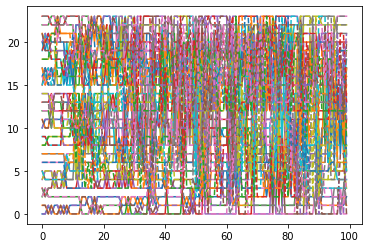

In [11]:
plt.plot(rep_index_pl[:100])
plt.plot(my_rep_index, '--')

[ 2. 12. 12. 10. 10. 10. 10. 19. 10. 12. 10. 10. 16. 13. 13. 13. 19. 16.
 16.  6. 16. 19. 19. 19. 19. 10.  2.  6.  6.  6.  6.  6.  6.  2.  2.  6.
  6.  6.  2.  6.  6.  6.  6.  2.  2. 19.  6.  6.  6. 16. 16. 19.  1.  1.
  6.  1. 16. 16. 23. 23. 16. 15.  6. 12. 15. 15. 15. 15. 19. 19.  6.  6.
 23. 23. 23. 23. 15.  1. 15. 16. 19. 15. 16. 16. 16. 16. 12. 15. 12. 12.
 12. 23. 19. 15. 15. 15.  2. 15. 15. 15. 15. 15. 16.  2. 20. 20. 15. 15.
  2.  2. 15.  2.  6.  2.  2.  2.  2.  2.  2. 20.  2.  2.  5.  5.  2.  2.
  2.  5.  5.  2. 12. 12.  2.  1.  1. 20.  1.  1.  1. 23. 16. 16.  1.  1.
  2.  1.  1.  1.  1.  1. 16. 16.  1.  2.  1.  2.  2.  2. 20.  1.  1. 20.
 20. 20. 20. 16. 16. 12.  1. 12. 12. 12. 19. 19.  4. 16.  4. 19. 16. 19.
 19. 19. 19. 12. 12. 12. 12. 16. 16.  4.  5.  5.  5.  5.  5.  7.  1.  7.
  7.  2.  5.  7.  5.  7. 12.  7. 12.  5.  5.  7.  7.  2.  6.  2.  6.  2.
  7.  7.  6.  6.  6.  6.  6. 16.  6.  6. 19. 19. 16. 23. 16. 19.  7.  7.
 19. 19. 19.  7. 19. 19. 19.  4.  4. 19.  4.  6.  6

Text(0.5, 1.0, 'replica_index at T = 18')

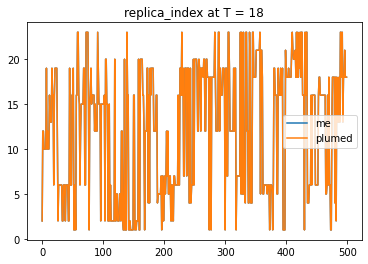

In [11]:
n_temp = 18
sup = 9500
inf = 9000

print(my_rep_index[inf:sup, n_temp])

print(rep_index_pl[inf:sup, n_temp])

plt.plot(my_rep_index[inf:sup, n_temp], '-', label='me')
plt.plot(rep_index_pl[inf:sup, n_temp], '-', label='plumed')
plt.legend()
plt.title('replica_index at T = %i' % n_temp)

# plt.savefig('compare_replica_index.pdf', format='pdf', bbox_inches='tight')

In [12]:
my_rep_temp = np.argsort(my_rep_index, axis=1)
rep_temp_pl = np.argsort(rep_index_pl, axis=1)

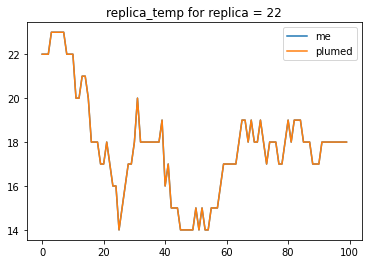

In [26]:
n_replica = 22

plt.title('replica_temp for replica = %i' % n_replica)
plt.plot(my_rep_temp[:, n_replica], '-', label='me')
plt.plot(rep_temp_pl[:100, n_replica], '-', label='plumed')
plt.legend()
plt.show()

so, those which overlap are those starting with the same value at position 0 !!

### look at the trajectory
to fix the threshold

In [6]:
start_frame = 0

In [8]:
trajs = get_trajectory(paths_traj[:2], n_replicas, 0, 2, 10)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

In [8]:
trajs = get_trajectory(paths_traj, n_replicas, start_frame, 2, 10)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

KeyboardInterrupt: 

In [9]:
print(trajs[0].shape)

(24, 37164)


(array([[4.100e+01, 2.500e+01, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.100e+01,
         4.900e+01, 5.300e+01, 1.800e+01, 2.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 5.800e+01,
         1.080e+03, 5.473e+03, 4.718e+03, 6.550e+02, 2.800e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 5.000e+00, 3.000e+01, 2.800e+01, 1.200e+01, 0.000e+00,
         0.000e+00, 0.000

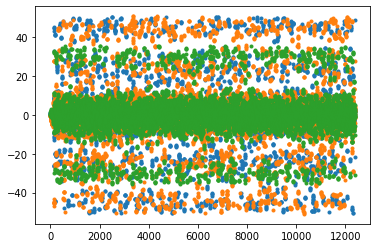

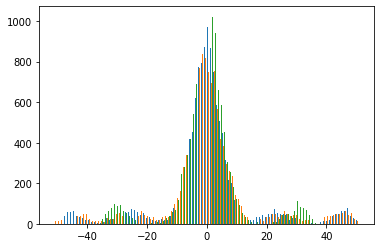

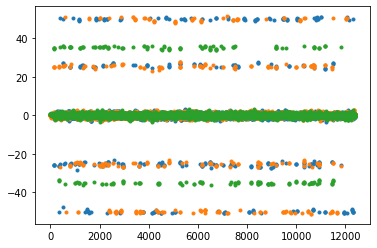

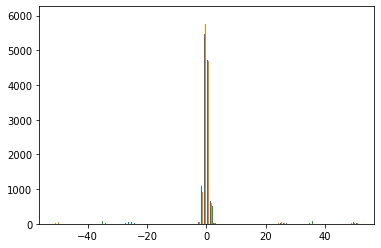

In [43]:
i = 5

single_diff = trajs[i][1] - trajs[i - 1][0]

plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

single_diff = trajs[i][1] - trajs[i - 1][1]

plt.figure()
plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

### box cell

In [9]:
xtc_read = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0)

xtc_read[start_frame][:].shape#.flatten()

(12388, 3)

In [12]:
vars(xtc_read)



array([51.0491  , 51.0491  , 51.049175, 59.999985, 59.999985, 90.      ],
      dtype=float32)

In [10]:
from demuxing_fun import reciprocal_lattice, periodical_distance

In [11]:
xtc_read = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0)
ts = xtc_read.ts.dimensions

out = reciprocal_lattice(ts)

In [21]:
h = reciprocal_lattice(ts, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

diff = distance.cdist(trajs[8], trajs[9], my_fun)

In [30]:
print(trajs[8][0, :6])
print(trajs[9][0, :6])
print(trajs[9][1, :6])

[41.77     36.760002 10.960001 41.65     36.75     10.01    ]
[39.2      37.79      7.91     39.58     37.61      8.780001]
[41.930004 36.83     11.220001 41.89     37.200005 10.33    ]


In [22]:
diff

array([[ 8.66417999,  1.09675474, 12.1195643 , 15.87683305, 20.86489111,
        22.3112346 , 22.98603471, 18.61725426, 23.60242364, 23.53819379,
        23.78657611, 23.31433879, 23.61815048, 23.88749206, 23.97487122,
        23.95773834, 23.91237464, 23.71834378, 23.79948424, 23.58762593,
        24.01813334, 24.04240715, 24.17730415, 24.14137264],
       [ 1.06805673,  8.71697099,  9.02165458, 13.4037457 , 19.80021846,
        21.69296026, 22.55241972, 17.12647745, 23.36889474, 23.53950919,
        23.61019726, 23.13950917, 23.51664803, 23.66494565, 23.86508851,
        24.03681197, 23.83809293, 24.07312593, 24.02018872, 23.53615171,
        23.84133709, 24.26546121, 24.18128845, 24.10721727],
       [ 8.97896194, 12.09374351,  1.14742959, 10.03736526, 18.15784875,
        20.85691668, 21.99939849, 14.41046857, 23.15561138, 23.33980544,
        23.52052371, 22.88253683, 23.55555996, 23.99604653, 23.95694885,
        23.98926354, 23.84682763, 24.10176729, 23.97040235, 23.62302451,
  

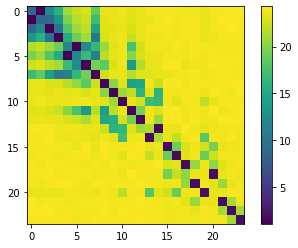

In [23]:
plt.imshow(diff)
plt.colorbar()

triclinic crystal system

- https://github.com/MDAnalysis/mdanalysis/blob/develop/package/MDAnalysis/coordinates/XTC.py

- https://aflow.org/p/triclinic_lattice.html

- https://watermark.silverchair.com/ appendix B: crystal systems and the reciprocal lattice

`xtc_read` returns the edge lengths and the angles $(a, b, c, \alpha, \beta, \gamma)$.

In our case, this means: the simulation box is a parallelepiped with edges

$\vec a_1 = \hat x$,   $\vec a_2 = \hat y$,   $\vec a_3 = \frac{1}{2}\hat x + \frac{1}{2}\hat y + \frac{\sqrt 2}{2}\hat z$

in units of $51.0491$.


distances in triclinic boxes with PBCs:

- https://github.com/mdtraj/mdtraj/issues/908

In this case, two angles are approx. 60° and the third is 90°. This means, 

In [15]:
unit_length = 51.0491

36.097164783470184

In [35]:
n_frame = 5
n_temp = 1

trajs[n_frame][n_temp].shape

(12388, 3)

In [46]:
diff = np.abs(trajs[n_frame][1] - trajs[n_frame - 1][0])

print(diff)

arg = 2*np.pi*(diff[:, 0] + diff[:, 1] + np.sqrt(2)*diff[:, 2])
cos_dist = 1 - np.cos(arg)

cos_dist = 1 - np.cos(np.sum(arg))



cos_dist

[[1.1000023e+00 4.0000916e-02 9.5000076e-01]
 [1.2400017e+00 4.9000168e-01 8.0999947e-01]
 [1.1300049e+00 2.8000259e-01 9.8999977e-01]
 ...
 [2.4910000e+01 2.4570004e+01 3.5740002e+01]
 [1.9699993e+00 2.4000549e-01 5.6000137e-01]
 [4.9450005e+01 7.9998016e-02 2.6000023e-01]]


1.533962607383728

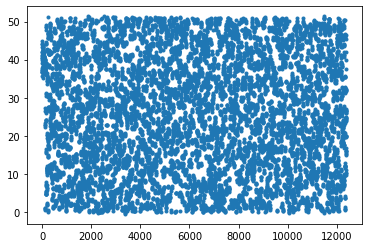

In [14]:
plt.plot(xtc_read[3][:][:, 1], '.')

In [ ]:
cos_diff = trajs[i][1] - trajs[i - 1][0]


In [75]:
my_vec = np.random.rand(20)

print(my_vec)

my_vec[2::3]

[0.84813077 0.60749879 0.60258524 0.4851856  0.77893403 0.34344637
 0.68319988 0.52786189 0.86560355 0.30189143 0.07392064 0.8329246
 0.09610098 0.03374846 0.34581896 0.92978378 0.58980338 0.52357675
 0.33434325 0.91044506]


array([0.60258524, 0.34344637, 0.86560355, 0.8329246 , 0.34581896,
       0.52357675])

In [136]:
def my_fun(x1, x2):
    unit_length = 51.0491
    diff = np.abs(x2 - x1)
    arg = 2*np.pi*(diff[::3] + diff[1::3] + np.sqrt(2)*diff[2::3])/unit_length
    cos_dists = 1 - np.cos(arg)
    cos_dist = np.mean(cos_dists)
    # cos_dist = 1 - np.cos(np.sum(arg))
    return cos_dist, cos_dists

In [142]:
def my_fun3(x1, x2):
    unit_length = 51.0491
    diff = np.abs(x2 - x1)
    diff[::3] -= np.rint(diff[::3]/unit_length)*unit_length
    diff[1::3] -= np.rint(diff[1::3]/unit_length)*unit_length
    diff[2::3] -= np.rint(diff[2::3]*np.sqrt(2)/unit_length)*unit_length/np.sqrt(2)
    return diff

In [124]:
def my_fun2(x1, x2):
    return (x1 - x2)**2

In [126]:
my_fun2(trajs[i - 1][0], trajs[i][0])

array([2.8900674e-02, 4.0001830e-04, 1.0889995e-01, ..., 1.2959975e-01,
       1.5999970e-01, 4.8999974e-01], dtype=float32)

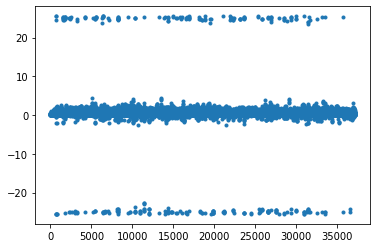

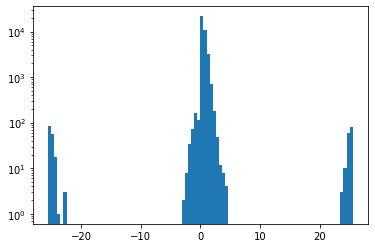

In [144]:
plt.plot(my_fun3(trajs[i - 1][0], trajs[i][0]), '.')

plt.figure()
plt.hist(my_fun3(trajs[i - 1][0], trajs[i][0]), bins=100)
plt.yscale('log')

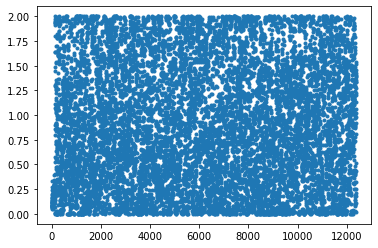

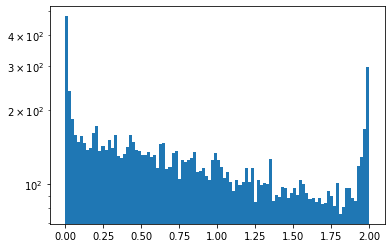

In [139]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][1])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][1])[1], bins=100)
plt.yscale('log')

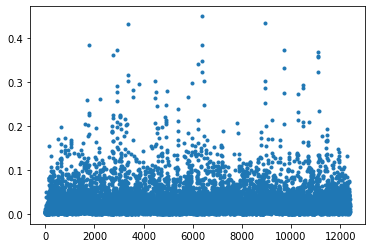

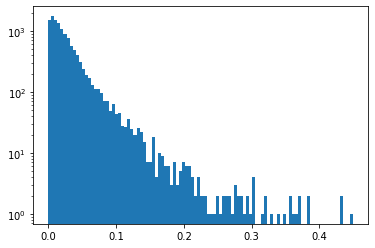

In [138]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][0])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
plt.yscale('log')

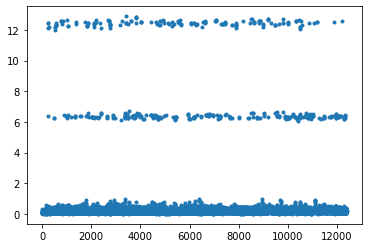

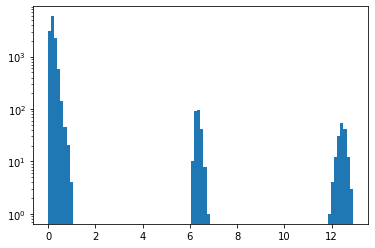

In [133]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][0])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
plt.yscale('log')

(array([3.025e+03, 5.896e+03, 2.259e+03, 5.900e+02, 1.400e+02, 4.600e+01,
        2.100e+01, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+01,
        9.300e+01, 9.500e+01, 4.100e+01, 8.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

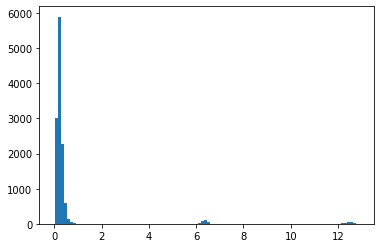

In [115]:
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
# plt.hist(my_fun(trajs[i - 1][0], trajs[i][1])[1], bins=100)

In [84]:
trajs[i].shape

(24, 37164)

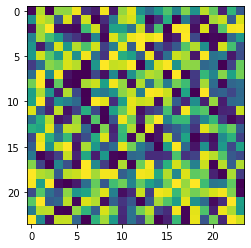

In [112]:
dist = distance.cdist(trajs[i - 1], trajs[i], metric=my_fun)

plt.imshow(dist)

In [69]:
def my_flatten(traj_frame):
    return np.array([traj_frame[j].flatten() for j in range(len(traj_frame))])

In [70]:
x = my_flatten(trajs[i - 1])
x_new = my_flatten(trajs[i])

distance.cdist(x, x_new)

array([[1025.15181184, 2713.68740052, 3301.36662288, 3060.54348993,
        3550.73327793, 3420.10854579, 3625.44014265, 3611.93891578,
        3677.34224637, 3625.21607998, 3650.92723408, 3676.66489877,
        3631.96855676, 3619.84603197, 3684.27459523, 3666.22527088,
        3660.48630294, 3632.22154499, 3632.37752519, 3671.89413356,
        3676.06097538, 3694.34987117, 3633.92111292, 3679.42342084],
       [2700.81447608, 1035.43197946, 3159.78272926, 2725.85233549,
        3479.88537712, 3347.97962964, 3579.9741573 , 3625.42109252,
        3663.37291943, 3622.33950027, 3644.59226711, 3662.00842651,
        3630.98890877, 3610.72822021, 3663.17253349, 3639.79375834,
        3663.03760821, 3628.20235636, 3641.83476626, 3663.90097193,
        3667.21573849, 3671.15453804, 3664.31908094, 3680.03847856],
       [3068.16385185, 2734.96000023, 2879.83043279, 1069.9918083 ,
        3412.97069521, 3217.55340411, 3516.2176376 , 3569.92439532,
        3661.25645698, 3636.03652533, 3637.373

In [68]:
x

AttributeError: 'tuple' object has no attribute 'shape'

In [65]:
distance.cdist(x, x_new)#, metric=my_fun)

ValueError: XA must be a 2-dimensional array.

In [ ]:
trajs[i - 1]

In [48]:
i = 1

diff, ind = main_demuxing(trajs[i - 1], trajs[i])

plt.imshow(diff)

ValueError: XA must be a 2-dimensional array.

[[229.  33.  11.  29.  10.  10.   4.   7.  13.  10.   7.  17.   6.  12.
    8.  13.  10.   6.  12.   7.   9.  10.   9.   6.]
 [ 32. 252.  19.  22.  10.  14.   7.   5.   7.  12.   7.   6.   5.   6.
   11.   6.   7.   8.  12.   7.  12.  12.   6.   4.]
 [ 18.  21.  24. 210.  11.  16.  11.  10.   7.  11.  12.  12.   7.   8.
    5.   6.   7.  13.  10.   9.  13.   6.   7.   6.]
 [ 11.  17. 199.  24.  22.  28.  14.   5.   7.   5.  11.  10.   4.  15.
    9.   9.   9.   8.  13.   6.   5.   6.   4.  14.]
 [ 11.  15.  18.  20.  24. 202.  14.  16.  14.  10.   7.   5.   8.  11.
    6.   6.   4.   7.   9.  12.   5.  11.  10.   5.]
 [  8.   8.  23.  16. 195.  20.  21.  13.  11.   9.  12.   5.   3.   5.
   15.   3.   9.   6.   6.   9.   6.   8.  14.   3.]
 [  6.  11.   9.  16.  21.  22. 228.  22.  13.   7.   9.   4.   6.   9.
   10.   6.   6.  10.   5.   7.  17.   7.  12.   9.]
 [  8.  11.  12.  11.  12.   9.  16. 173.  20.  11.  10.  10.   8.   9.
    5.   9.  12.   9.   6.   8.   9.   9.   5.  10.]


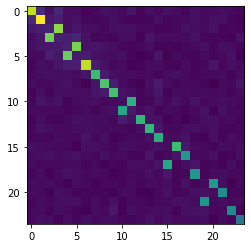

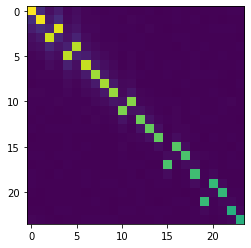

In [15]:
i = 1

for threshold in [1e-3, 1]:
    diff, ind = main_demuxing(trajs[i - 1], trajs[i], threshold=threshold)

    print(diff)

    plt.figure()
    plt.imshow(diff)

#### from https://github.com/mdtraj/mdtraj/issues/908

$H = (\vec a, \vec b, \vec c)$

$\vec s_{12} = H^{-1}\vec{AC}$

$\vec s_{12} \, -= \, \mathrm{np.round}(\vec s_{12})$

$||H \vec s_{12}||$

notice $H^{-1} = (\vec g_1, \vec g_2, \vec g_3)^T / 2\pi$

In [7]:
n_atoms = 2

# build unit cell and positions
# ts = mda.coordinates.base.Timestep(n_atoms)
ts_pos0 = np.array([0.9, 0.5, 0.1])
ts_pos1 = np.array([0.1, 0.5, 0.9])
dimensions = [1, np.sqrt(2), 1, 60, 60, 90]

# calculate H matrix and its inverse
def abc_to_hmatrix(a, b, c, alpha, beta, gamma, degrees=True):
        if degrees: alpha, beta, gamma = map(np.radians, (alpha, beta, gamma))
        result = np.zeros((3, 3))

        a = np.array((a, 0, 0))
        b = b * np.array((np.cos(gamma), np.sin(gamma), 0))
        bracket = (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
        c = c * np.array((np.cos(beta), bracket, np.sqrt(np.sin(beta) ** 2 - bracket ** 2)))

        result[:, 0] = a
        result[:, 1] = b
        result[:, 2] = c

        return result

hmat = abc_to_hmatrix(*dimensions)
hinv = np.linalg.inv(hmat)

# calculate distance according to Tuckerman
# s_1 = np.dot(hinv, ts_pos0)
# s_2 = np.dot(hinv, ts_pos1)
# s_12 = s_1 - s_2
s_12 = np.dot(hinv, ts_pos0 - ts_pos1)
s_12 -= np.round(s_12)
print('Expected distance by Tuckerman  ', np.linalg.norm(np.dot(hmat, s_12)))

# calculate distance by enumeration
dist = 100000
for i in range(-2, 2):
    for j in range(-2, 2):
        for k in range(-2, 2):
            dist = min(np.linalg.norm(ts_pos0+i*hmat[:, 0]+j*hmat[:,1]+k*hmat[:,2]-ts_pos1), dist)
print('Expected distance by enumeration', dist)

# calculate distance with transposed Hmat
s_1 = np.dot(hinv.T, ts_pos0)
s_2 = np.dot(hinv.T, ts_pos1)
s_12 = s_1-s_2
s_12 -= np.round(s_12)
print('Wrong distance by Tuckerman     ', np.linalg.norm(np.dot(hmat.T, s_12)))

# writer = mda.coordinates.DCD.DCDWriter('mdtraj-pbc.dcd', n_atoms)
# writer.write_next_timestep(ts)
# writer.close()

[ 1.36568542  0.4        -1.13137085]
Expected distance by Tuckerman   0.5904482620022894
Expected distance by enumeration 0.5904482620022893
Wrong distance by Tuckerman      0.23031443252638928


#### triclinic system: cosine distance

reciprocal lattice

In [61]:
xtc_read.ts

< Timestep 0 with unit cell dimensions [51.0491   51.0491   51.049175 59.999985 59.999985 90.      ] >

In [58]:
ts = np.array([1, 1, 1, 60, 60, 90])


In [59]:
out = reciprocal_lattice(ts, False)

In [60]:
[out[1][i]/(2*np.pi) for i in range(3)]

[array([ 1.00000000e+00, -6.12323400e-17, -7.07106781e-01]),
 array([ 0.        ,  1.        , -0.70710678]),
 array([0.        , 0.        , 1.41421356])]

### analysis of the results

In [4]:
my_rep_index = np.loadtxt('../../demuxing_results/2025_03_08_18_06_10_replica_index', delimiter=',')

In [13]:
check = rep_index_pl - my_rep_index[:-1]

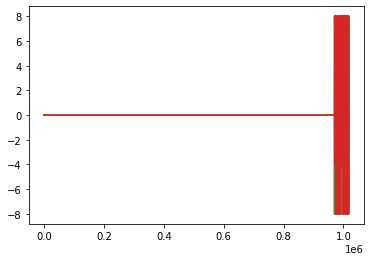

In [14]:
for i in range(check.shape[1]):
    plt.plot(check[:, i])

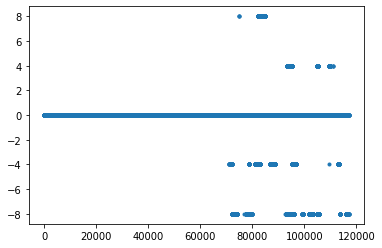

In [15]:
plt.plot(check[int(9e5):, 0], '.')
# plt.plot(check[int(8e5):, 1])

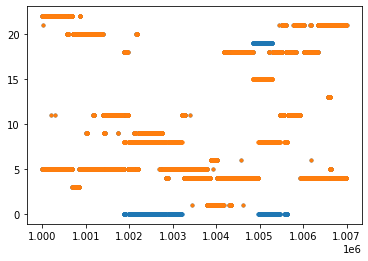

In [16]:
inf = int(10e5)
sup = int(10.07e5)  # len(rep_index_pl)
n_temp = 1

x = np.arange(inf, sup)
plt.plot(x, rep_index_pl[inf:sup, n_temp], '.')
plt.plot(x, my_rep_index[inf:sup, n_temp], '.')


In [5]:
my_rep_index.shape

(1008001, 24)

In [17]:
my_rep_temp = np.argsort(my_rep_index, axis=1)
rep_temp_pl = np.argsort(rep_index_pl, axis=1)

check2 = rep_temp_pl - my_rep_temp[:-1]

replica n. 1 is in complete agreement
replica n. 2 is in complete agreement
replica n. 3 is in complete agreement
replica n. 4 is in complete agreement
replica n. 5 is in complete agreement
replica n. 6 is in complete agreement
replica n. 7 is in complete agreement
replica n. 9 is in complete agreement
replica n. 10 is in complete agreement
replica n. 11 is in complete agreement
replica n. 12 is in complete agreement
replica n. 13 is in complete agreement
replica n. 14 is in complete agreement
replica n. 16 is in complete agreement
replica n. 17 is in complete agreement
replica n. 18 is in complete agreement
replica n. 20 is in complete agreement
replica n. 21 is in complete agreement
replica n. 22 is in complete agreement
replica n. 23 is in complete agreement


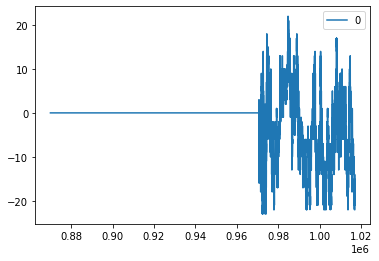

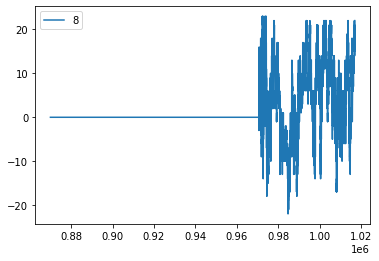

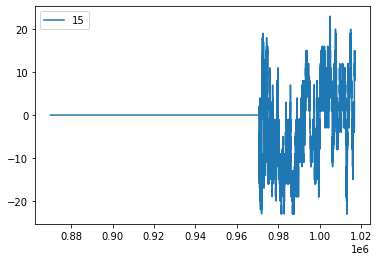

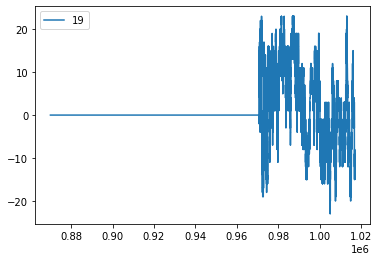

In [18]:
inf = int(8.7e5)
x = np.arange(inf, len(check2))

for i in range(check2.shape[1]):
    if np.count_nonzero(check2[:, i]) != 0:
        plt.figure()
        plt.plot(x, check2[inf:, i], label=i)
        plt.legend()
    else:
        print('replica n. %i is in complete agreement' % i)

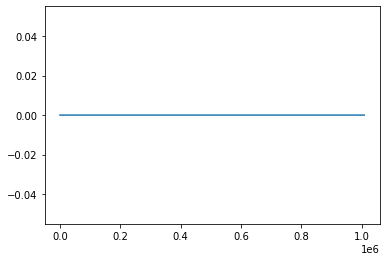

In [75]:
plt.plot(check2[:, 10])

In [9]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.p

In [35]:
# n_subtraj = -2
n_rep = 0

ns_frame = []

for path_traj in paths_traj:
    xtc_read = mda.coordinates.XTC.XTCReader(path_traj % n_rep)
    ns_frame.append(xtc_read.n_frames)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/si